In [19]:
import numpy as np
%matplotlib inline
from plotdevice import *
from plotdevice.plot_with_matplotlib import plot
import math

In [20]:
pt_7b = WandbRun("ai2-llm", "olmo3", "OLMo25", name="7B PT")
pt_32b = WandbRun("ai2-llm", "olmo3", "stego32-highlr-filter3", name="32B PT")

mt_7b = WandbRun("ai2-llm", "olmo-cookbook", "8730626c", name="7B MT")
mt_32b = WandbRun("ai2-llm", "olmo-cookbook", "stego32-midtraining-run-2", name="32B MT ingr1")

lc_7b = WandbRun("ai2-llm", "olmo3-7b-long-context", "fb13a737", name="7B LC")
lc_32b = WandbRun("ai2-llm", "olmo-cookbook", "stego32-longcontext-run-3", name="32B LC")

In [21]:
# Sanity check

def print_token_span(run: WandbRun) -> None:
    tokens = run.get_time_series("throughput/total tokens")
    print(f"{run.name}:\t{tokens.ys.max() / 1e9:.0f}B")

for run in [pt_7b, pt_32b, mt_7b, mt_32b, lc_7b, lc_32b]:
    print_token_span(run)

7B PT:	5930B
32B PT:	5696B
7B MT:	100B
32B MT ingr1:	100B
7B LC:	50B
32B LC:	100B


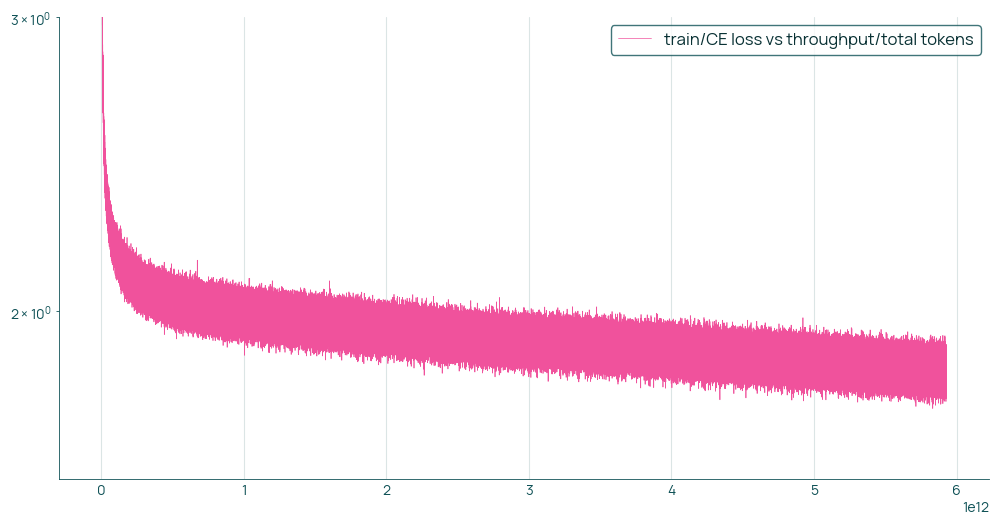

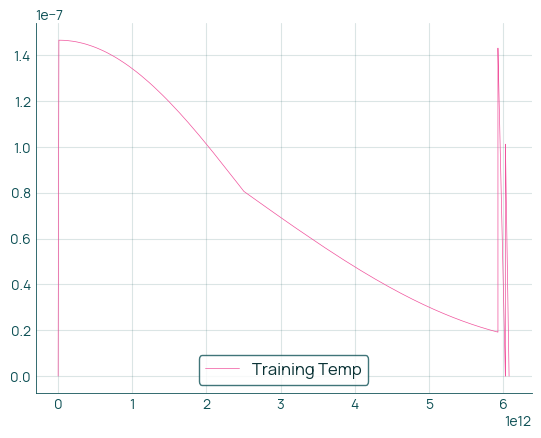

In [22]:
# 7B training temperature and loss

loss_7b = pt_7b.get_time_series("train/CE loss").transform_x_axis(pt_7b.get_time_series("throughput/total tokens"))
plot(loss_7b, logy=True, ylim=(None, 3))

lr_7b = pt_7b.get_time_series("optim/LR (group 0)").transform_x_axis(pt_7b.get_time_series("throughput/total tokens"))

# construct the concatenated training temperature plot
def lr_vs_tokens(run):
    return run.get_time_series("optim/LR (group 0)").transform_x_axis(run.get_time_series("throughput/total tokens"))
pt_7b_normlr = lr_vs_tokens(pt_7b)
mt_7b_normlr = lr_vs_tokens(mt_7b)
lc_7b_normlr = lr_vs_tokens(lc_7b)
max_x_seen = 0
for tt in [pt_7b_normlr, mt_7b_normlr, lc_7b_normlr]:
    tt.xs += max_x_seen
    max_x_seen = tt.xs.max()
    #tt.ys *= tt.ys
pt_7b_normlr.ys /= math.sqrt(512 * 8192)
mt_7b_normlr.ys /= math.sqrt(256 * 8192)
lc_7b_normlr.ys /= math.sqrt(64 * 65536)

training_temp_7b = TimeSeries(
    xs=np.concatenate([pt_7b_normlr.xs, mt_7b_normlr.xs, lc_7b_normlr.xs]),
    ys=np.concatenate([pt_7b_normlr.ys, mt_7b_normlr.ys, lc_7b_normlr.ys]),
    name="Training Temp",
    run_name="7B"
)

plot(training_temp_7b)

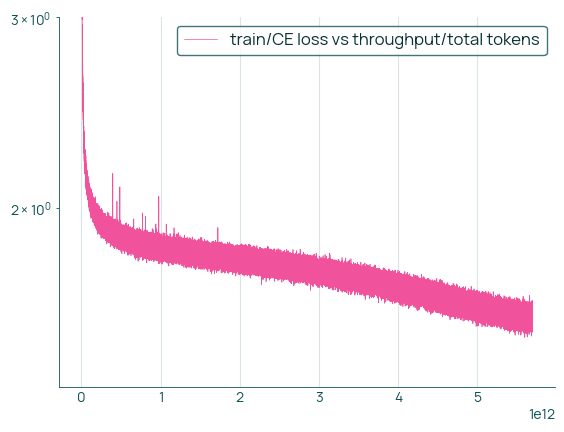

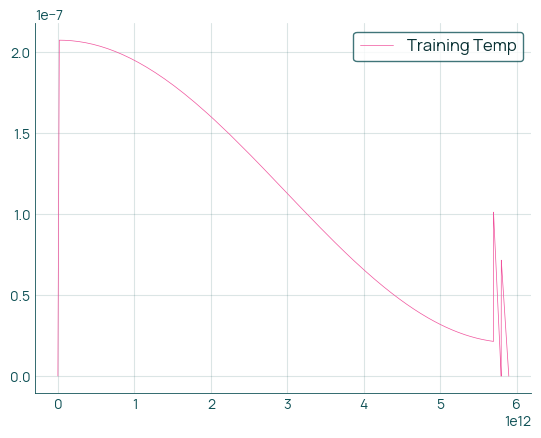

In [23]:
# 32B training temperature and loss

loss_32b = pt_32b.get_time_series("train/CE loss").transform_x_axis(pt_32b.get_time_series("throughput/total tokens"))
plot(loss_32b, logy=True, ylim=(None, 3))

lr_32b = pt_32b.get_time_series("optim/LR (group 0)").transform_x_axis(pt_32b.get_time_series("throughput/total tokens"))

# construct the concatenated training temperature plot
def lr_vs_tokens(run):
    return run.get_time_series("optim/LR (group 0)").transform_x_axis(run.get_time_series("throughput/total tokens"))
pt_32b_normlr = lr_vs_tokens(pt_32b)
mt_32b_normlr = lr_vs_tokens(mt_32b)
lc_32b_normlr = lr_vs_tokens(lc_32b)
max_x_seen = 0
for tt in [pt_32b_normlr, mt_32b_normlr, lc_32b_normlr]:
    tt.xs += max_x_seen
    max_x_seen = tt.xs.max()
    #tt.ys *= tt.ys
pt_32b_normlr.ys /= math.sqrt(1024 * 8192)
mt_32b_normlr.ys /= math.sqrt(512 * 8192)
lc_32b_normlr.ys /= math.sqrt(128 * 65536)

training_temp_32b = TimeSeries(
    xs=np.concatenate([pt_32b_normlr.xs, mt_32b_normlr.xs, lc_32b_normlr.xs]),
    ys=np.concatenate([pt_32b_normlr.ys, mt_32b_normlr.ys, lc_32b_normlr.ys]),
    name="Training Temp",
    run_name="32B"
)

plot(training_temp_32b)

# Plots for paper

In [ ]:
import matplotlib.pyplot as plt
from ai2_theme.ai2_theme import apply_ai2_theme, get_shade
apply_ai2_theme()

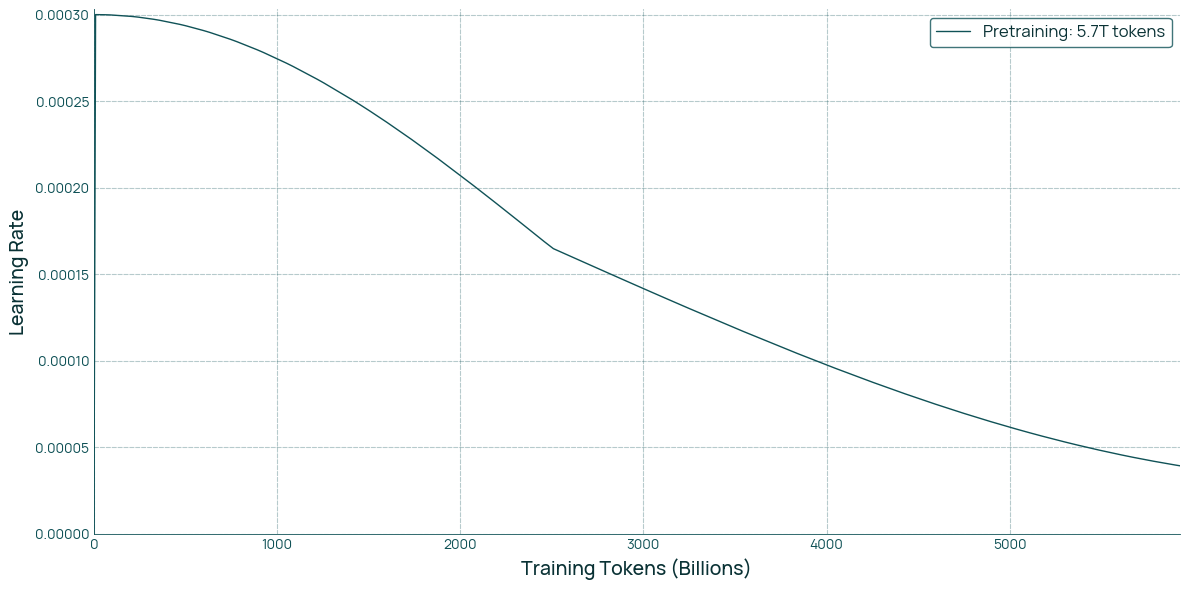

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(
    lr_7b.xs / 1e9,
    lr_7b.ys,
    label="Pretraining: 5.7T tokens",
    linewidth=1,
    color=get_shade("teal", 1)[0],
)
#plt.plot(
#    mt_7b_normlr.xs / 1e9,
#    mt_7b_normlr.ys,
#    label="Midtraining: 100B tokens",
#    linewidth=1,
#    color=get_shade("pink", 1)[0],
#)
#plt.plot(
#    lc_7b_normlr.xs / 1e9,
#    lc_7b_normlr.ys,
#    label="Long-Context Ext.: 100B tokens",
#    linewidth=1,
#    color=get_shade("green", 1)[0],
#)

plt.xlabel("Training Tokens (Billions)", fontsize=14)
plt.ylabel("Learning Rate", fontsize=14)
#plt.title(f"Olmo 3 7B Learning Rate Schedule", fontsize=14, fontweight="bold")
plt.grid(True, alpha=0.3, linestyle="--")
plt.xlim(0, np.max(lr_7b.xs / 1e9))
plt.ylim(0, np.max(lr_7b.ys) * 1.01)

#plt.text(20, 0.00045, "← 2000 warm-up steps", fontsize=12, color=get_shade("teal", 1)[0])
#plt.text(5175, 0.00015, "no warm-up", fontsize=12, color=get_shade("pink", 1)[0])
#plt.text(5105, 0.00020, "200 warm-up steps →", fontsize=12, rotation=-45, color=get_shade("green", 1)[0])

plt.legend()
plt.tight_layout()
plt.show()

## 7B plot

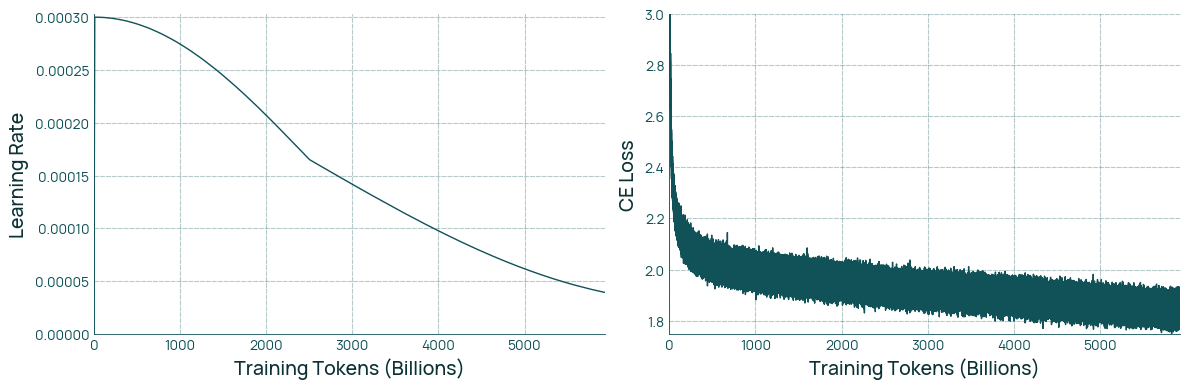

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# lr
axs[0].plot(
    lr_7b.xs / 1e9,
    lr_7b.ys,
    label="Pretraining: 5.7T tokens",
    linewidth=1,
    color=get_shade("teal", 1)[0],
)
axs[0].set_xlabel("Training Tokens (Billions)", fontsize=14)
axs[0].set_ylabel("Learning Rate", fontsize=14)
axs[0].grid(True, alpha=0.3, linestyle="--")
axs[0].set_xlim(0, np.max(lr_7b.xs / 1e9))
axs[0].set_ylim(0, np.max(lr_7b.ys) * 1.01)

# loss
axs[1].plot(
    loss_7b.xs / 1e9,
    loss_7b.ys,
    label="Pretraining: 5.7T tokens",
    linewidth=1,
    color=get_shade("teal", 1)[0],
)
axs[1].set_xlabel("Training Tokens (Billions)", fontsize=14)
axs[1].set_ylabel("CE Loss", fontsize=14)
axs[1].grid(True, alpha=0.3, linestyle="--")
axs[1].set_xlim(0, np.max(loss_7b.xs / 1e9))
axs[1].set_ylim(np.min(loss_7b.ys), 3)

#plt.legend()
plt.tight_layout()
plt.show()

## 32B plot

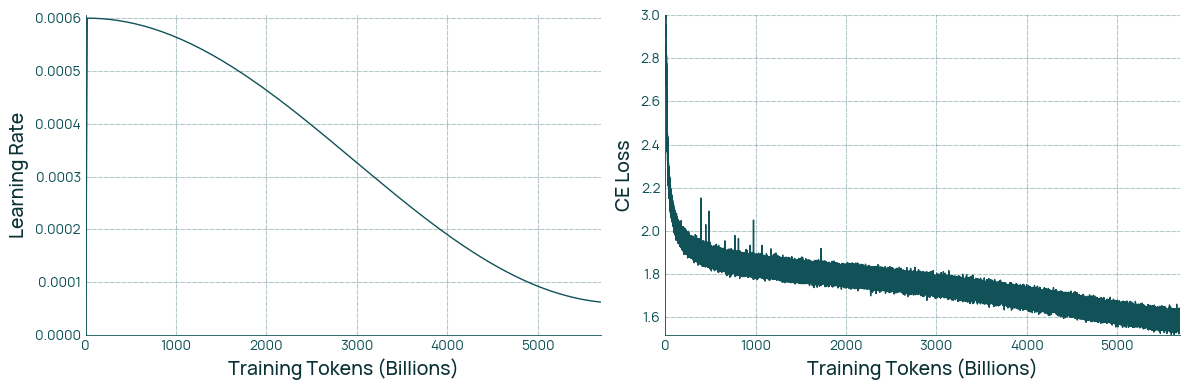

In [37]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# lr
axs[0].plot(
    lr_32b.xs / 1e9,
    lr_32b.ys,
    label="Pretraining: 5.5T tokens",
    linewidth=1,
    color=get_shade("teal", 1)[0],
)
axs[0].set_xlabel("Training Tokens (Billions)", fontsize=14)
axs[0].set_ylabel("Learning Rate", fontsize=14)
axs[0].grid(True, alpha=0.3, linestyle="--")
axs[0].set_xlim(0, np.max(lr_32b.xs / 1e9))
axs[0].set_ylim(0, np.max(lr_32b.ys) * 1.01)

# loss
axs[1].plot(
    loss_32b.xs / 1e9,
    loss_32b.ys,
    label="Pretraining: 5.7T tokens",
    linewidth=1,
    color=get_shade("teal", 1)[0],
)
axs[1].set_xlabel("Training Tokens (Billions)", fontsize=14)
axs[1].set_ylabel("CE Loss", fontsize=14)
axs[1].grid(True, alpha=0.3, linestyle="--")
axs[1].set_xlim(0, np.max(loss_32b.xs / 1e9))
axs[1].set_ylim(np.min(loss_32b.ys), 3)

#plt.legend()
plt.tight_layout()
plt.show()